# 서포트 벡터 머신

서포트 벡터 머신(SVM, Support Vector Machine)은 분류와 회귀 분석에 모두 사용할 수 있는 특히 강력하고 유연한 지도 학습 알고리즘이다. 이번 절에서는 서포트 벡터 머신에 대한 직관을 기르고 이를 분류 문제에 활용하는 법을 알아보겠다. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns; sns.set()

## 서포트 벡터 머신의 동기

앞에서 베이즈 분류에 대해 다룰 때 각 기반 클래스의 분포를 설명하는 간단한 모델을 배웠고 이 생성 모델을 사용해 확률적으로 새 점의 레이블을 결정했다. 거기서는 생성 분류의 일례로 다뤘지만 여기서는 그 대신 판별 분류(discriminative classification)로 알아보겠다. 다시 말해, 각 클래스를 모델링하기보다는 간단히 클래스를 서로 나누는 선이나 곡선, 다양체를 구할 것이다. 

이에 대한 예제로 두 클래스로 잘 구분되어 있는 간단한 분류 작업을 생각해보자.

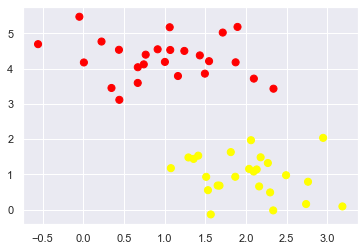

In [3]:
from sklearn.datasets.samples_generator import make_blobs

X, y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.6)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

선형 판별 분류기는 두개의 데이터 집합을 분리하는 직선을 그려서 분류 모델을 만들고자 할 것이다. 여기서 보여준 것과 같은 2차원 데이터의 경우에 이 작업은 직접 할 수도 있다. 그러나 이 두 클래스 사이를 완벽하게 구별할 수 있는 구분선이 하나 이상 있다는 문제점을 바로 발견하게 될 것이다.

그 구분 선을 다음과 같이 그릴 수 있다. 

(-1.0, 3.5)

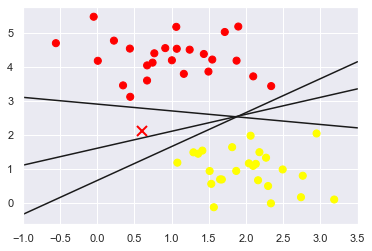

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)
for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')
plt.xlim(-1, 3.5)

이 세개의 구분자는 서로 매우 다르지만 표본들 사이를 완벽하게 판별한다. 어느 것을 선택하느냐에 따라 새로운 데이터 점에 항ㄹ당되는 레이블이 달라질 것이다. 단순한 직관으로 '클래스 사이에 선을 그리는 것'만으로는 충분하지 않으며 조금 더 깊이 생각해야 한다.

## 서포트 벡터 머신 : 마진 최대화

서포트 벡터 머신은 이 문제를 개선하는 한 가지 방법을 제공한다. 직관적으로 클래스 사이에 단순히 폭이 0인 선을 그리는 것이 아니라 각 선에서 주변의 가장 가까운 점에 이르는 너비의 마진을 그리는 것이다. 서포트 벡터 머신에서는 이 마직은 극대화하는 건이 최적의 모델이 된다. 서포트 벡터 머신은 이러한 **최대 마진 추정기**의 대표적인 예다.

이 데이터에 실제 적합한 결과를 살펴보자. 당분간 선형 커널을 사용하고 모수 $C$에 매우 큰 수를 설정할 것이다. 

In [5]:
from sklearn.svm import SVC 
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

여기서 무슨 일이 일어나고 있는지 더 잘 확인하기 위해 SVM 결정 경계를 플로팅 할 간단한 함수를 만들어보자. 

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    # 2차원 SVC를 위한 의사결정 함수 플로팅하기
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # 모델 평가를 위한 그리드 생성
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # 의사 결정 경계와 마진 플로팅
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyle=['--', '-', '--'])
    # 서포트 벡터 플로팅
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s = 300, linewidth=1, facecolors='none')
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

/Users/a1101497/opt/anaconda3/envs/study/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: The following kwargs were not used by contour: 'linestyle'


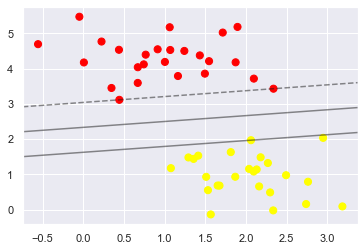

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

이것이 점들의 두 집합 사이에서 마진이 최대화되는 구분선이다. 일부 훈련 데이터 점이 마진에 닿아있음을 주목하자. 이 점들은 이 적합의 중심 원소로서 서포트 벡터(support vector)라고도 하는데, 이 알고리즘이 여기서 나온 것이다. 사이킷런에서 이 점들의 정체는 분류기의 `support_vectors` 속성에 저장되어 있다.

In [8]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

이 분류기가 성공할 수 있었던 핵심은 적합에서 오직 서포트 벡터의 위치만 중요하게 여긴다는 점이다. 즉, 올바른 쪽에 위치한 마진으로부터 멀리 떨어진 점들은 적합을 변경하지 않는다. 엄밀히 말해서 이 점들은 마진을 지나가지 않는 한 모델을 적합하는데 사용되는 손실함수(loss function)에 기여하지 않기 때문에 그것들의 위치나 개수는 중요하지 않다.

예를 들어, 이 데이터 세트에서 첫 60개의 점으로부터 학습한 모델과 120개의 점으로부터 학습한 모델을 플로팅해보면 이 사실을 알 수 있다. 

/Users/a1101497/opt/anaconda3/envs/study/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: The following kwargs were not used by contour: 'linestyle'
/Users/a1101497/opt/anaconda3/envs/study/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: The following kwargs were not used by contour: 'linestyle'


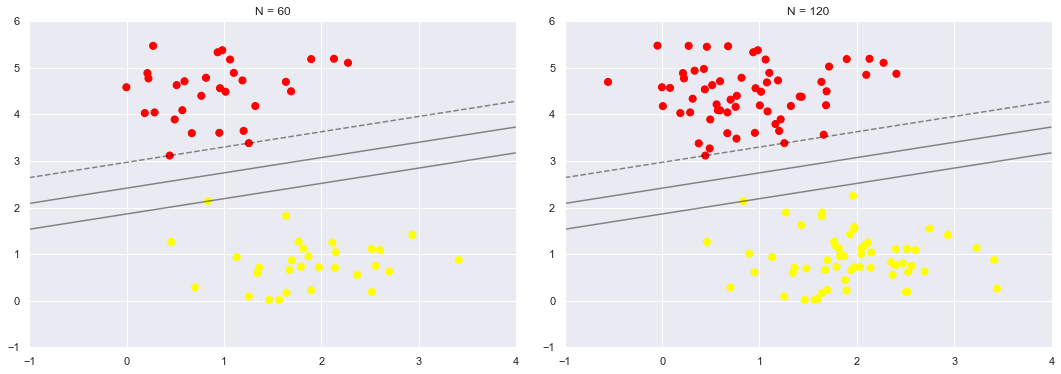

In [9]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2, random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)
    
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

왼쪽 그림은 60개의 훈련 데이터 점에 대한 모델과 서포트 벡터를 나타낸다. 오른쪽 그림에서는 훈련 점을 두배로 늘렸지만 모델은 바뀌지 않았다. 왼쪽 그림의 서포트 벡터 세개가 그대로 오른쪽 그림의 서포트 벡터가 되기 때문이다. 마진에서 떨어진 점들의 정확한 행위에 무감각하다는 점이 SVM 모델의 강점 중 하나이다.

이 노트북을 실행중이라면 IPython의 대화형 위젯을 사용해 SVM 모델의 이 특징을 대화식으로 확인할 수 있다. 

In [11]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 200], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 200), value=10), Output()), _dom_classes=('widget…

## 선형 경계 너머 : 커널 SVM

SVM은 커널(kernel)과 결합할 때 막강해진다. 앞에서 기저 함수 회귀를 다룰 때 커널의 한 형태를 봤다. 거기서 데이터를 다항식 기저 함수와 가우스 기저 함수로 정의된 고차원 공간에 사영해서 선형 분류기로 비선형 관계를 적합할 수 있었다.

SVM 모델에서도 같은 개념을 사용할 수 있다. 커널의 중요성을 알기 위해 선형적으로 분리되지 않는 데이터를 살펴보자. 

/Users/a1101497/opt/anaconda3/envs/study/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: The following kwargs were not used by contour: 'linestyle'


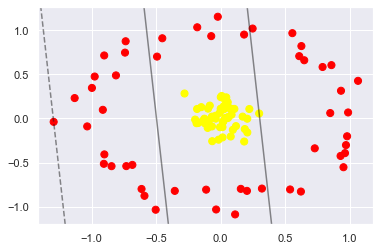

In [13]:
from sklearn.datasets.samples_generator import make_circles

X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

어떠한 선형 판별법도 이 데이터를 구분해낼 수 없다는 것은 분명하다. 앞에서 배운 기저함수 회귀를 가지고 어떻게 하면 이 데이터를 **고차원에 사영해서** 선형 분류기로도 분류할 수 있게 만들지 고민해보자. 예를 들어, 간단한 사영 중 하나로 가운데 무리에 중심을 둔 **방사형 기저 함수**(radical basis function)를 계산하는 것을 들 수 있다. 

In [14]:
r = np.exp(-(X**2).sum(1))

3차원 플롯을 사용해 이 추가 데이터 차원을 시각화 할 수 있다. 이 노트북을 실행중이라면 슬라이더를 사용해 플롯을 회전시킬 수 있을 것이다. 

In [15]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')
    

interact(plot_3D, elev=[-90, 90], azip=(-180, 180), X=fixed(X), y=fixed(y))

interactive(children=(Dropdown(description='elev', options=(-90, 90), value=-90), IntSlider(value=30, descript…

<function __main__.plot_3D(elev=30, azim=30, X=array([[ 4.42701786e-02,  2.39332119e-01],
       [ 5.73293388e-02,  5.33963632e-03],
       [ 2.56359806e-02,  1.05210193e-01],
       [-1.49880826e-02, -2.39757408e-01],
       [-3.54737881e-01, -8.19588857e-01],
       [ 2.07586437e-01, -1.57908391e-01],
       [ 9.53003990e-01, -5.51706365e-01],
       [ 6.09989350e-01,  7.05983116e-01],
       [ 9.64823261e-01, -3.92094665e-01],
       [ 8.55276432e-02,  4.25662539e-02],
       [-4.51600086e-01,  9.08334653e-01],
       [-1.25155128e-01, -2.09276585e-03],
       [ 1.07140756e-01,  1.08399502e-01],
       [ 1.87971390e-01, -1.19469737e-01],
       [ 2.48747937e-01,  1.01839700e+00],
       [-3.78897658e-02,  3.13336082e-02],
       [ 1.19583994e-01, -8.61082557e-02],
       [ 3.50491055e-02,  5.15909617e-03],
       [-9.75685417e-01,  4.75037552e-01],
       [-8.34992218e-02,  1.45915723e-01],
       [ 8.78309873e-03,  2.54708923e-01],
       [ 6.48823895e-01,  6.59392131e-01],
       

차원을 추가함으로써 r=0.7 에 구분 평면을 그리면 데이터를 평범하게 선형으로 분리할 수 있게 된다.

이때 사영을 선택하고 신중하게 조정해야 한다. 만일 방사형 기저 함수의 중앙을 정확한 위치에 맞추지 않았다면 이처럼 깔끔하게 선형으로 분리되는 결과를 얻을 수 없었을 것이다. 사용할 최적의 기저 함수를 자동으로 찾아주기를 바라기 때문에 보통은 그러한 선택을 해야한다는 것 자체가 문제가 된다.

이 목적을 달성할 수 있는 한 가지 전략은 데이터 세트의 모든 점에 중심을 둔 기저 함수를 계산하고 SVM 알고리즘이 그 결과를 꼼꼼히 살펴 추려내게 하는 것이다. 이러한 유형의 기저 함수 변환을 **커널 변환**(kernel transformation)이라고 하는데, 각 쌍의 점들 사이의 유사관계에 기반을 두고 있기 때문이다. 

N개의 점을 N차원으로 사영하는 이 전략의 잠재적 문제는 N이 커질수록 계산량이 늘어난다는 것이다. 그러나 **커널 기법**(kernel trick)으로 알려진 간결한 절차 덕분에 커널 사영의 N차원을 전부 구성하지 않고도 암묵적으로 커널 변환된 데이터에 적합시킬 수 있다. 이 커널 기법은 SVM에 내장되어 있으며 SVM 방식이 매우 막강한 이유 중 하나이기도 하다.

사이킷런에서는 모델 초모수인 `kernel`을 사용해 선형 커널을 RBF(radial basis function, 방사형 기저 함수) 커널로 바꿈으로써 간단히 커널 변환된 SVM을 적용할 수 있다. 

In [16]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

/Users/a1101497/opt/anaconda3/envs/study/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: The following kwargs were not used by contour: 'linestyle'


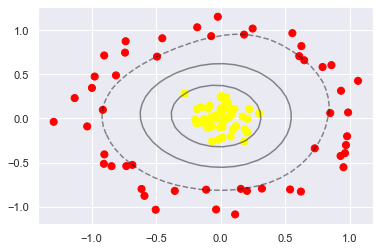

In [17]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=300, lw=1, facecolors='none')

이 커널 SVM을 사용하면 적절한 비선형 결정 경계를 알 수 있다. 이 커널 변환 전략은 머신러닝에서 빠른 선형 기법을 빠른 비선형 기법으로 전환하기 위해 종종 사용되며, 특히 커널 기법을 사용할 수 있는 모델에서 자주 사용된다. 